# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

Stuttgart is the sixth largest city in Germany with a rapidly growing population. It has a huge variety of restaurants for every taste and, thus, to start a restaurant business in this area is not an easy task.

Our stakeholder is willing to open the beer restaurant in the city of Stuttgart with middle-high level prices.
Of course, choosing a location for business is one of the stressful and controversial tasks, since there are a lot of criteria that have to be satisfied in order to achieve the highest revenue.
Here are some of them:
- the density of other restaurants
- the density of specifically beer restaurants
- population density around the location
- solvency of the population around the location
- ...

In this project, we will implement the basic analysis and try to find the most optimal Borough to open the beer restaurant according to those criteria. It's obvious, that there are many additional factors, such as distance from parking places or distance from the main streets, but this analysis can be done after choosing the Borough, and thus will not be done within the scope of this project.

## 2. Data <a name="data"></a>

### 2.1 Data description

Based on criteria listed above the following data will be utilized in our analysis:
- the number of restaurants within the certain radius of each borough (Foresquare API)
- the net income per person in each borough. Since the restaurant will have middle-high prices, it is important to consider the solvency of population. Source: Socialmonitoring der Landeshauptstadt Stuttgart (https://statistik.stuttgart.de/statistiken/sozialmonitoring/atlas/Stadtbezirke/out/atlas.html)
- the population and the population density of the borough. Source: Statistikatlas Stuttgart (https://statistik.stuttgart.de/statistiken/statistikatlas/atlas/atlas.html?indikator=i0&select=00)
- the population above 18 years age. It is obvious, that potential visitors of our beer restaurant are men and women of full age. Source: Statistikatlas Stuttgart (https://statistik.stuttgart.de/statistiken/statistikatlas/atlas/atlas.html?indikator=i0&select=00)
- the coordinates of the borough. Source: Open street map (https://nominatim.openstreetmap.org/details.php?place_id=17476218)





### 2.2 Data Preparation

First, let's import all the libraries that we will need

In [67]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Load the coordinates of the boroughs into a dataframe.

In [68]:
df = pd.read_csv('stuttgart_bezirke.txt')
print(df.shape)
df.head()

(23, 3)


,Borough,Latitude,Longitude
0,Bad Cannstatt,48.807109,9.221557
1,Birkach,48.728574,9.203406
2,Botnang,48.778495,9.129532
3,Degerloch,48.744052,9.180481
4,Feuerbach,48.803635,9.149803


Load the population and population density of each borough into a new dataframe.

In [69]:
df_pop = pd.read_excel ('Bezirke_bevolkerung.xlsx')
df_pop.rename(columns = {'Bezirk':'Borough', 'Bevölkerungsdichte':'Population Density','Einwohner':'Population'}, inplace = True)
df_pop.head()

,Borough,Population Density,Population
0,Mitte,6322,24060
1,Nord,4094,27903
2,Ost,5371,48526
3,Süd,4652,44601
4,West,7558,52214


Load the the percentage of underages in each borough into a new dataframe.

In [70]:
df_18 = pd.read_excel ('Bezirke_bevolkerung_unter_18.xlsx')
df_18.rename(columns = {'Bezirk':'Borough', '% Anteil unter 18-Jährige':'Percentage under 18 years old'}, inplace = True)
df_18.head()

,Borough,Percentage under 18 years old
0,Mitte,10.2
1,Nord,15.5
2,Ost,14.1
3,Süd,13.7
4,West,12.6


Let's now apply some math into a dataframes **df_pop** and **df_18** to obtain the population of full age and create a new dataframe **df_pop**

In [71]:
#merge
df_pop['Population Density'] = round(df_pop['Population Density']*(1-0.01*df_18['Percentage under 18 years old']))
df_pop['Population'] = round(df_pop['Population']*(1-0.01*df_18['Percentage under 18 years old']))
# change the floats to integers
df_pop[['Population Density','Population']] = df_pop[['Population Density','Population']].astype('int64')
df_pop.head()

,Borough,Population Density,Population
0,Mitte,5677,21606
1,Nord,3459,23578
2,Ost,4614,41684
3,Süd,4015,38491
4,West,6606,45635


In [72]:
df_pop.dtypes

Borough               object
Population Density     int64
Population             int64
dtype: object

Load the the data of **Net income per person** in each borough into a new dataframe.

In [73]:
# amount of income
url = 'https://statistik.stuttgart.de/statistiken/sozialmonitoring/atlas/Stadtbezirke/out/Profil/report_Stadtbezirke_i20_2011.html'
list_df = pd.read_html(url, header = 0)
df_income = list_df[1]

In [74]:
df_income.rename(columns = {'Steuerpflichtiges Einkommen - 2011':'Borough', 'Steuerpflichtiges Einkommen - 2011.1':'Net income per person'}, inplace = True)
df_income.head()

,Borough,Net income per person
0,Nord,114.4
1,Degerloch,114.0
2,Birkach,111.9
3,Sillenbuch,109.5
4,Vaihingen,107.7


In [75]:
df_income['Borough'].replace({'Nord':'Stuttgart-Nord','Süd':'Stuttgart-Süd','West':'Stuttgart-West','Ost':'Stuttgart-Ost','Mitte':'Stuttgart-Mitte'}, inplace = True)
df_pop['Borough'].replace({'Nord':'Stuttgart-Nord','Süd':'Stuttgart-Süd','West':'Stuttgart-West','Ost':'Stuttgart-Ost','Mitte':'Stuttgart-Mitte'}, inplace = True)

In [76]:
df_income.head()

,Borough,Net income per person
0,Stuttgart-Nord,114.4
1,Degerloch,114.0
2,Birkach,111.9
3,Sillenbuch,109.5
4,Vaihingen,107.7


In [77]:
df_pop.head()

,Borough,Population Density,Population
0,Stuttgart-Mitte,5677,21606
1,Stuttgart-Nord,3459,23578
2,Stuttgart-Ost,4614,41684
3,Stuttgart-Süd,4015,38491
4,Stuttgart-West,6606,45635


In [78]:
df = df.join(df_pop.set_index('Borough'), on='Borough')
df = df.join(df_income.set_index('Borough'), on='Borough')

In [80]:
df.head(23)

,Borough,Latitude,Longitude,Population Density,Population,Net income per person
0,Bad Cannstatt,48.807109,9.221557,3798,59685,92.2
1,Birkach,48.728574,9.203406,1953,6030,111.9
2,Botnang,48.778495,9.129532,5162,11021,103.7
3,Degerloch,48.744052,9.180481,1755,14080,114.0
4,Feuerbach,48.803635,9.149803,2206,25497,104.1
5,Hedelfingen,48.755863,9.219398,1167,8546,96.5
6,Möhringen,48.726912,9.151997,1866,28072,103.9
7,Mühlhausen,48.845610,9.226179,2361,21528,86.7
8,Münster,48.826620,9.202133,2611,5771,88.6
9,Obertürkheim,48.772290,9.280816,1324,7228,97.3


#### Use geopy library to get the latitude and longitude values of Stuttgart.

In [81]:
address = 'Stuttgart'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stuttgart are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stuttgart are 48.7784485, 9.1800132.


#### Define Foursquare Credentials and Version

In [82]:
CLIENT_ID = 'A5S2CJNU43XNBJEADGVEDLOR024ZP5BC5KZY2E1F0WT0DZEI' # your Foursquare ID
CLIENT_SECRET = 'GIPWZSDNB1GYTVSRWTFV2E2JZBHBDYCORNL3MVRVDUOWQADI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A5S2CJNU43XNBJEADGVEDLOR024ZP5BC5KZY2E1F0WT0DZEI
CLIENT_SECRET:GIPWZSDNB1GYTVSRWTFV2E2JZBHBDYCORNL3MVRVDUOWQADI


#### Create a function to repeat the process of exploring the venues for all the neighborhoods in Stuttgart

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Create a new dataframe called stuttgart_venues.

In [84]:
LIMIT = 100
radius = 1000
stuttgart_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   radius = radius
                                  )

Bad Cannstatt
Birkach
Botnang
Degerloch
Feuerbach
Hedelfingen
Möhringen
Mühlhausen
Münster
Obertürkheim
Plieningen
Sillenbuch
Stammheim
Stuttgart-Mitte
Stuttgart-Nord
Stuttgart-Ost
Stuttgart-Süd
Stuttgart-West
Untertürkheim
Vaihingen
Wangen
Weilimdorf
Zuffenhausen


In [85]:
print(stuttgart_venues.shape)
stuttgart_venues.head()

(557, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bad Cannstatt,48.807109,9.221557,Kurpark,48.808592,9.221199,Park
1,Bad Cannstatt,48.807109,9.221557,Kursaal Bad Cannstatt,48.807854,9.223137,Event Space
2,Bad Cannstatt,48.807109,9.221557,The Little Greek Taverna,48.805730,9.216561,Taverna
3,Bad Cannstatt,48.807109,9.221557,Tsimpo,48.802200,9.218207,Cupcake Shop
4,Bad Cannstatt,48.807109,9.221557,Motel One Stuttgart-Bad Cannstatt,48.803450,9.214496,Hotel


In [86]:
#stuttgart_venues['Venue Category'].value_counts()

Let's check how many venues were returned for each neighborhood

In [87]:
stuttgart_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Bad Cannstatt,69,69,69,69,69,69
Birkach,7,7,7,7,7,7
Botnang,13,13,13,13,13,13
Degerloch,24,24,24,24,24,24
Feuerbach,19,19,19,19,19,19
Hedelfingen,5,5,5,5,5,5
Möhringen,30,30,30,30,30,30
Mühlhausen,6,6,6,6,6,6
Münster,17,17,17,17,17,17


In [88]:
stuttgart_venues[(stuttgart_venues['Venue Category'].str.contains('Beer', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Beer Garden', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Restaurant', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Bar', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Taverna', regex=False))].count()

Borough              156
Borough Latitude     156
Borough Longitude    156
Venue                156
Venue Latitude       156
Venue Longitude      156
Venue Category       156
dtype: int64

In [89]:
stuttgart_venues[(stuttgart_venues['Venue Category'].str.contains('Beer', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Beer Garden', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('German Restaurant', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Bar', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Taverna', regex=False))].count()

Borough              61
Borough Latitude     61
Borough Longitude    61
Venue                61
Venue Latitude       61
Venue Longitude      61
Venue Category       61
dtype: int64

In [90]:
stuttgart_restaurant = stuttgart_venues[(stuttgart_venues['Venue Category'].str.contains('Beer', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Beer Garden', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Restaurant', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Bar', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Taverna', regex=False))].groupby(['Borough']).count()
stuttgart_restaurant.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
stuttgart_restaurant.rename(columns = {'Venue Category':'Number of restaurants'}, inplace=True)
stuttgart_restaurant.head()

,Number of restaurants
Borough,
Bad Cannstatt,24
Birkach,1
Botnang,1
Degerloch,5
Feuerbach,8


In [91]:
stuttgart_beer = stuttgart_venues[(stuttgart_venues['Venue Category'].str.contains('Beer', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Beer Garden', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('German Restaurant', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Bar', regex=False)) |
                 (stuttgart_venues['Venue Category'].str.contains('Taverna', regex=False))].groupby(['Borough']).count()
stuttgart_beer.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
stuttgart_beer.rename(columns = {'Venue Category':'Number of beer restaurants'}, inplace=True)
stuttgart_beer.head()

,Number of beer restaurants
Borough,
Bad Cannstatt,10
Degerloch,2
Feuerbach,3
Möhringen,2
Münster,1


In [92]:
# join above dataframe to the main df
df = df.join(stuttgart_restaurant, on='Borough')
df = df.join(stuttgart_beer, on='Borough')

In [93]:
df.head()

,Borough,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
0,Bad Cannstatt,48.807109,9.221557,3798,59685,92.2,24.0,10.0
1,Birkach,48.728574,9.203406,1953,6030,111.9,1.0,NaN
2,Botnang,48.778495,9.129532,5162,11021,103.7,1.0,NaN
3,Degerloch,48.744052,9.180481,1755,14080,114.0,5.0,2.0
4,Feuerbach,48.803635,9.149803,2206,25497,104.1,8.0,3.0


In [95]:
df = df.fillna(0)
#df[['Number of restaurants', 'Number of beer restaurants']] = df[['Number of restaurants', 'Number of beer restaurants']].astype('int64')
df.head(23)

,Borough,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
0,Bad Cannstatt,48.807109,9.221557,3798,59685,92.2,24.0,10.0
1,Birkach,48.728574,9.203406,1953,6030,111.9,1.0,0.0
2,Botnang,48.778495,9.129532,5162,11021,103.7,1.0,0.0
3,Degerloch,48.744052,9.180481,1755,14080,114.0,5.0,2.0
4,Feuerbach,48.803635,9.149803,2206,25497,104.1,8.0,3.0
5,Hedelfingen,48.755863,9.219398,1167,8546,96.5,2.0,0.0
6,Möhringen,48.726912,9.151997,1866,28072,103.9,7.0,2.0
7,Mühlhausen,48.845610,9.226179,2361,21528,86.7,1.0,0.0
8,Münster,48.826620,9.202133,2611,5771,88.6,2.0,1.0
9,Obertürkheim,48.772290,9.280816,1324,7228,97.3,2.0,1.0


## 3. Methodology and Analysis <a name="methodology"></a>


After cleaning and preparing the data, let us identify the steps, that have to be performed in order to find the most optimal boroughs.
Firstly, we will apply some basic exploratory analysis to our data. For that let's find the location of each borough on the map. Then we can visually inspect some values in our data with the help of bar charts.
Secondly, we have the possibility to reduce the number features in data frame by replacing them with more reasonable data.
Finally, we will perform cluster analysis to find the best cluster of boroughs with meaningful features.


### 3.1 Exploratory Data Analysis

Let's first derive some basic statistical values of our data.

In [30]:
df.describe()

,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,48.778805,9.184656,2860.782609,22591.217391,100.386957,6.782609,2.652174
std,0.038893,0.047688,1481.888689,14612.365234,8.675006,9.967933,5.041723
min,48.711395,9.088648,873.000000,5771.000000,84.800000,0.000000,0.000000
25%,48.748536,9.151674,1909.500000,10776.500000,94.550000,1.500000,0.000000
50%,48.777659,9.180481,2361.000000,21528.000000,102.500000,3.000000,1.000000
75%,48.805372,9.220478,3628.500000,29902.500000,106.650000,7.000000,2.000000
max,48.850726,9.280816,6606.000000,59685.000000,114.400000,40.000000,23.000000


It's also would be quite useful to visualize the center locations of each borough. For that, we need to create a map of Stuttgart with boroughs superimposed on top.

In [31]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Visualization. In our case barcharts will be utilized.

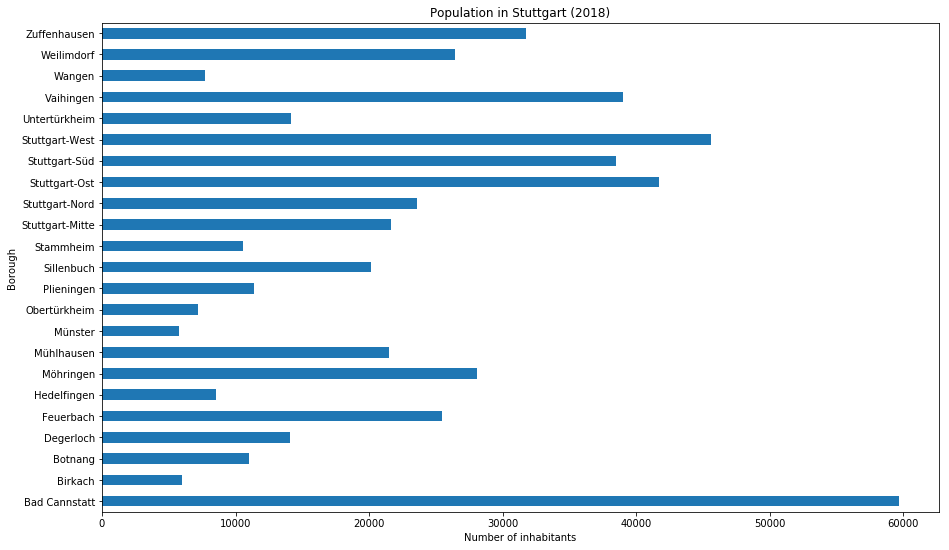

In [42]:
import matplotlib.pyplot as plt
# step 2: plot data
df[['Borough', 'Population']].plot(kind='barh', figsize=(15, 9), legend = None)

plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population in Stuttgart (2018)') # add title to the plot
plt.yticks (np.arange(23), df['Borough'])
plt.show()

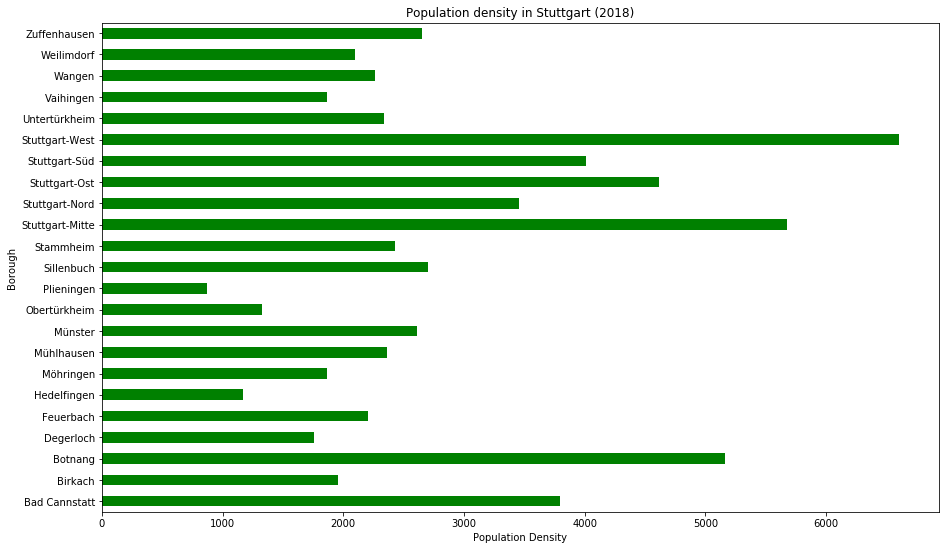

In [41]:
# step 2: plot data
# step 2: plot data
df[['Borough', 'Population Density']].plot(kind='barh', figsize=(15, 9), legend = None, color='green')

plt.xlabel('Population Density') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population density in Stuttgart (2018)') # add title to the plot
plt.yticks (np.arange(23), df['Borough'])
plt.show()

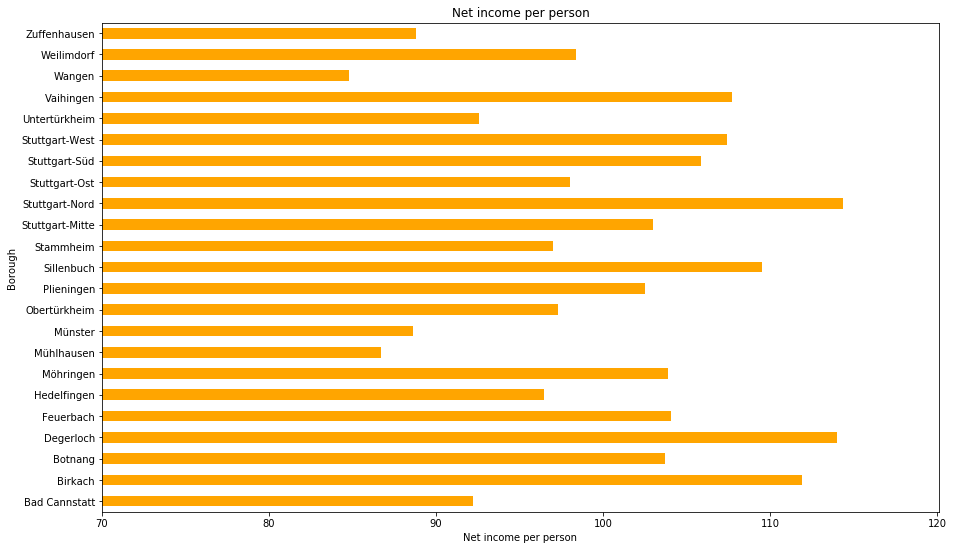

In [40]:

df[['Borough', 'Net income per person']].plot(kind='barh', figsize=(15, 9), legend = None, color = 'orange')
plt.xlim(left=70)
plt.xlabel('Net income per person') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Net income per person') # add title to the plot
plt.yticks (np.arange(23), df['Borough'])
plt.show()

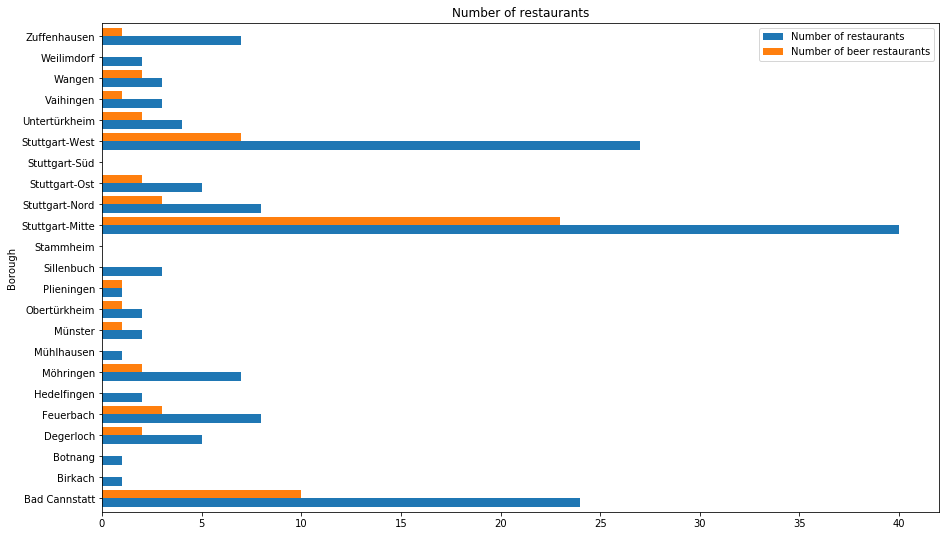

In [96]:
# step 2: plot data
# step 2: plot data
df[['Number of restaurants', 'Number of beer restaurants']].plot(kind='barh', figsize=(15, 9), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Number of restaurants') # add title to the plot
plt.yticks (np.arange(23), df['Borough'])
plt.show()

### 3.2 Cluster Analysis

In order to identify groups (clusters) with similar characteristics, let's us apply the unsupervised learning method to our data, namely K-Means algorithm.
But before that, we can reduce the number of features and remove columns "Population", "Number of restaurants" and "Number of beer restaurants". These three columns we can replace with two new ones, namely, "Number of restaurants per thousand people" and "Number of beer restaurants per thousand people".

In [46]:
#df.drop([13], inplace =True)
#df.reset_index(inplace-True)
df_clusters = df.drop(['Borough','Latitude', 'Longitude', 'Population Density'],axis = 1)
df_clusters['Number of restaurants per 1000 people'] = df_clusters['Number of restaurants']/(df_clusters['Population']/1000)
df_clusters['Number of beer restaurants per 1000 people'] = df_clusters['Number of beer restaurants']/(df_clusters['Population']/1000)
#df_clusters['Net income per person'] = df_clusters['Net income per person']*(-1)
#df_clusters = df_clusters.drop(['Cluster Labels', 'Population', 'Number of restaurants', 'Number of beer restaurants'], axis = 1)
df_clusters = df_clusters.drop(['Population', 'Number of restaurants', 'Number of beer restaurants'], axis = 1)
df_clusters.head()

,Net income per person,Number of restaurants per 1000 people,Number of beer restaurants per 1000 people
0,92.2,0.402111,0.167546
1,111.9,0.165837,0.000000
2,103.7,0.090736,0.000000
3,114.0,0.355114,0.142045
4,104.1,0.313762,0.117661


And of course, it is crucial, to perform normalization:

In [47]:
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[-0.96495102,  0.30953572,  0.22406884],
       [ 1.35697839, -0.34090642, -0.55662692],
       [ 0.39049001, -0.54765509, -0.55662692],
       [ 1.60449371,  0.18015555,  0.10524562],
       [ 0.43763578,  0.06631895, -0.00837623],
       [-0.45813394, -0.15318448, -0.55662692],
       [ 0.41406289, -0.11097899, -0.22465323],
       [-1.61320543, -0.66956738, -0.55662692],
       [-1.389263  ,  0.15660915,  0.25078647],
       [-0.36384239, -0.03570613,  0.08803034],
       [ 0.24905268, -0.55629791, -0.14846446],
       [ 1.07410374, -0.38786427, -0.55662692],
       [-0.39920173, -0.7974436 , -0.55662692],
       [ 0.3079849 ,  4.2991392 ,  4.40358787],
       [ 1.65163949,  0.13662009,  0.03624559],
       [-0.28133729, -0.46723066, -0.33305996],
       [ 0.64979177, -0.7974436 , -0.55662692],
       [ 0.82658842,  0.8313242 ,  0.1581113 ],
       [-0.91780525, -0.02000242,  0.10132036],
       [ 0.86194776, -0.58563714, -0.43712593],
       [-1.83714786,  0.2693037 ,  0.647

To identify the optimal number of clusters, the Elbow method is used:

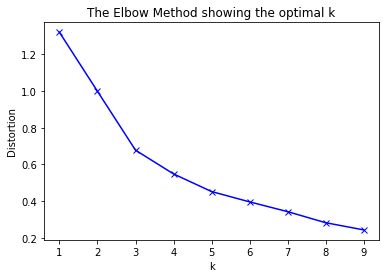

In [48]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Great! On the graph, we can see that 3 clusters are enough:

In [49]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24] 

array([0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0,
       0], dtype=int32)

Let's insert the Cluster labels into our master dataframe.

In [50]:
#df = df.drop('Cluster Labels', axis = 1)
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Borough,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
0,0,Bad Cannstatt,48.807109,9.221557,3798,59685,92.2,24.0,10.0
1,2,Birkach,48.728574,9.203406,1953,6030,111.9,1.0,0.0
2,2,Botnang,48.778495,9.129532,5162,11021,103.7,1.0,0.0
3,2,Degerloch,48.744052,9.180481,1755,14080,114.0,5.0,2.0
4,2,Feuerbach,48.803635,9.149803,2206,25497,104.1,8.0,3.0


Now, it's time to create maps representing our clusters. The first map is illustrating the clusters where the radius of the Circle marker is proportional to a Number of restaurants per 1000 people in each borough.

In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'black', 'blue']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Cluster Labels'], df_clusters[:,1]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*5+15,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The second map is illustrating the clusters where the radius of the Circle marker is proportional to a Net income per person in each borough.

In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'black', 'blue']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Cluster Labels'], df['Net income per person']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*0.5-25,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can see that one of the clusters (black circle) consists only of one borough - Stuttgart-Mitte. 
Let's look at the scatter plots of our data and define our clusters with colors. The grey circle marker is representing the centroid of each cluster. Don't forger that our data is normalized, so the axes do not deliver real values.

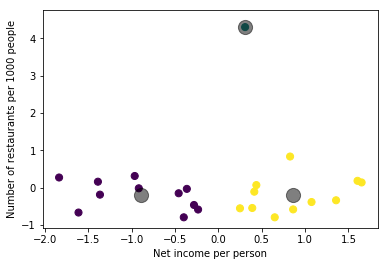

In [62]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Net income per person')
plt.ylabel('Number of restaurants per 1000 people')
plt.show()

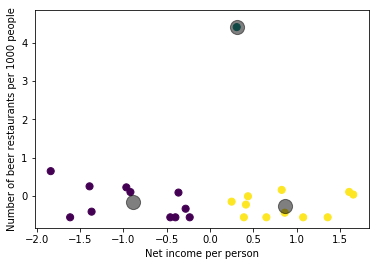

In [63]:
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);
plt.xlabel('Net income per person')
plt.ylabel('Number of beer restaurants per 1000 people')
plt.show()

Wow! One can observe obvious outlier here. This borough has to high concentraition of beer restaurants and restaurants in general. From maps above we can easily say that it is Stuttgart-Mitte.
Two other clusters were defined according to a Net income per person. Let us see which boroughs belongs to which clusters.

In [58]:
df[(df['Cluster Labels'] == 0)]

,Cluster Labels,Borough,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
0,0,Bad Cannstatt,48.807109,9.221557,3798,59685,92.2,24.0,10.0
5,0,Hedelfingen,48.755863,9.219398,1167,8546,96.5,2.0,0.0
7,0,Mühlhausen,48.845610,9.226179,2361,21528,86.7,1.0,0.0
8,0,Münster,48.826620,9.202133,2611,5771,88.6,2.0,1.0
9,0,Obertürkheim,48.772290,9.280816,1324,7228,97.3,2.0,1.0
12,0,Stammheim,48.850726,9.154724,2431,10532,97.0,0.0,0.0
15,0,Stuttgart-Ost,48.776972,9.207365,4614,41684,98.0,5.0,2.0
18,0,Untertürkheim,48.783154,9.255246,2339,14164,92.6,4.0,2.0
20,0,Wangen,48.773070,9.238802,2260,7742,84.8,3.0,2.0
21,0,Weilimdorf,48.810704,9.105939,2098,26403,98.4,2.0,0.0


In [59]:
df[(df['Cluster Labels'] == 2)]

,Cluster Labels,Borough,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
1,2,Birkach,48.728574,9.203406,1953,6030,111.9,1.0,0.0
2,2,Botnang,48.778495,9.129532,5162,11021,103.7,1.0,0.0
3,2,Degerloch,48.744052,9.180481,1755,14080,114.0,5.0,2.0
4,2,Feuerbach,48.803635,9.149803,2206,25497,104.1,8.0,3.0
6,2,Möhringen,48.726912,9.151997,1866,28072,103.9,7.0,2.0
10,2,Plieningen,48.711395,9.198991,873,11416,102.5,1.0,1.0
11,2,Sillenbuch,48.742184,9.222216,2704,20164,109.5,3.0,0.0
14,2,Stuttgart-Nord,48.796661,9.176252,3459,23578,114.4,8.0,3.0
16,2,Stuttgart-Süd,48.753021,9.132492,4015,38491,105.9,0.0,0.0
17,2,Stuttgart-West,48.777659,9.151351,6606,45635,107.4,27.0,7.0


In [60]:
df[(df['Cluster Labels'] == 1)]

,Cluster Labels,Borough,Latitude,Longitude,Population Density,Population,Net income per person,Number of restaurants,Number of beer restaurants
13,1,Stuttgart-Mitte,48.779495,9.179876,5677,21606,103.0,40.0,23.0


## 4. Results and discussion <a name="results"></a>

During the analysis, three clusters were defined. One cluster, that consists of only one area, has been defined as the outsider, due to the high number of competitors, which means that the placement of beer restaurant in that area is too risky venture. Two other groups were clustered according to the amount income per person. It is obvious, that the cluster with highest average income per person has the highest priority for us (Cluster 2).  
Stuttgart-Sud and Stuttgart-Nord are the most attractive options in terms of distances to the center of their own cluster and relatively high value of income per person. However, one can perform further analysis of this particular cluster with additional features, such as distance to the center of city or to the center of cluster.
After defining a borough one can perform deeper analysis to find the best exact location of the restaurant taking into account factors such as number of parking places in the vicinity of the spot or distances to the main streets.   
What could be done better?  
Foursquare doesn't represent the full picture, since many venues are not on the list. For that reason, another maps could be utilized such as Google map or Openstreet map.  
Boroughs have too complex geometry, thus defining the closest venues within the certain radius brings additional error to our analysis.




## 5. Conclusion <a name="conclusion"></a>

To conclude, the basic data analysis was performed to identify the most optimal boroughs for the placement of the beer restaurant in the city of Stuttgart. During the analysis, several important statistical features of the boroughs were explored and visualized. Furthermore, clustering helped to highlight the group of optimal areas. Finally, Stuttgart Sud and Stuttgart Nord were chosen as the most attractive options for the further analysis.  